# Trying to understand the relationship between various factors and flat escape profiles

In [1]:
import collections
import itertools
import math
import os
import re
import string
import warnings
import xml.etree.ElementTree as ElementTree

from IPython.display import display, HTML
from IPython.display import display, SVG
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import natsort
import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import svgutils

import yaml

Read config file

In [2]:
with open('../data/escape_profiles_config.yaml') as f:
    config = yaml.safe_load(f)

with open('../config.yaml') as f:
    global_config = yaml.safe_load(f)

Make results directory

In [3]:
resultsdir='results/flat_profiles_results/'
os.makedirs(resultsdir, exist_ok=True)

In [4]:
def svg_dim(svgfile, dim):
    """Get width or height `dim` of `svgfile` in points."""
    return float(ElementTree.parse(svgfile)
                            .getroot().attrib[dim]
                            .replace('px', '')
                            .replace('pt', '')
                            )

Read in data file

In [5]:
metadata_file = 'data/escape_profile_metadata.csv'
metadata = pd.read_csv(metadata_file)
display(HTML(metadata.head().to_html(index=False)))

subject_name,day,dose,sample,sorting dilution,NT50,staining background,FACS plot shape,escape map,sample_type,time_category
M01,119,250ug,M01 (day 119),80,375.5,medium-high,normal-no escape,456-484,vaccine,late
M02,36,250ug,M02 (day 36),1250,8304.5,low,normal,flat,vaccine,early
M02,119,250ug,M02 (day 119),200,2402.0,low-medium,normal,456-484 low magnitude,vaccine,late
M03,119,250ug,M03 (day 119),200,1103.0,medium-high,normal-no escape,core,vaccine,late
M04,119,250ug,M04 (day 119),200,1657.8,low,extra escape,flat,vaccine,late


Figure out what's going on with my subjective categorization of `staining background` and `FACS plot shape`

In [6]:
staining_background_order = ['low', 'low-medium', 'medium', 'medium-high', 'high']
facs_shape_order = ['extra escape', 'normal', 'normal-no escape', 'no escape']
map_order=['456-484', 
           '456-484 low magnitude', 
           '456-484 noisy', 
           '456-484 low magnitude - noisy',
           '443-450', 
           'core',
           'flat - noisy', 
           'flat', ]

In [7]:
kwargs = {
          'staining background': lambda x: pd.Categorical(x['staining background'], 
                                                          ordered=True, 
                                                          categories=staining_background_order
                                                         ),
          'FACS plot shape': lambda x: pd.Categorical(x['FACS plot shape'], 
                                                      ordered=True, 
                                                      categories=facs_shape_order
                                                     ),
          'escape map': lambda x: pd.Categorical(x['escape map'], 
                                                 ordered=True, 
                                                 categories=map_order
                                                ),
         }

metadata = (metadata
            .assign(log10_NT50=lambda x: np.log10(x['NT50']),
                    log2_sortdilution=lambda x: np.log2(x['sorting dilution']),
                    **kwargs,
                   )
           )

display(HTML(metadata.tail().to_html(index=False)))

subject_name,day,dose,sample,sorting dilution,NT50,staining background,FACS plot shape,escape map,sample_type,time_category,log10_NT50,log2_sortdilution
subject I,102,NaN,subject I (day 102),80,587.409029,high,no escape,443-450,convalescent,late,2.768941,6.321928
subject J,15,NaN,subject J (day 15),200,610.352369,low,normal,core,convalescent,early,2.785581,7.643856
subject J,121,NaN,subject J (day 121),1250,504.160069,high,no escape,flat,convalescent,late,2.702568,10.287712
subject K,29,NaN,subject K (day 29),500,354.381763,low,normal,456-484 low magnitude,convalescent,early,2.549471,8.965784
subject K,103,NaN,subject K (day 103),200,408.812677,low,normal,456-484 low magnitude,convalescent,late,2.611524,7.643856


In [8]:
params=[('staining background', 'FACS plot shape'),
        ('staining background', 'escape map'),
        ('FACS plot shape', 'escape map'),
        ('log2_sortdilution', 'escape map'),
        ('log10_NT50', 'escape map'),
       ]

In [9]:
svgs = []
plot_n = 0

for (x,y), n in zip(params, range(len(params))):

    print(f"\nMaking plot for {x} vs. {y}:")
    plot_n+=1
    
    if n < max(range(len(params))):
        p = (ggplot(metadata) +
             aes(x, y, color='sample_type') +
             geom_jitter(size=2.5, alpha=0.25, width=0.15, height=0.15, random_state=0) +
             theme_classic() +
             theme(axis_text_x=element_text(angle=90),
                   figure_size=(2,2),
                  )+
             scale_color_manual(values=CBPALETTE[1:], guide=False)
             )
    
    else:
        p = (ggplot(metadata) +
             aes(x, y, color='sample_type') +
             geom_jitter(size=2.5, alpha=0.25, width=0.15, height=0.15, random_state=0) +
             theme_classic() +
             theme(axis_text_x=element_text(angle=90),
                   figure_size=(2,2),
                  )+
             scale_color_manual(values=CBPALETTE[1:])
             )
    
    plotfile = f'./{resultsdir}/nofacet_plot{plot_n}.svg'
    svgs.append(plotfile)
    print(f"Saving to {plotfile}")
    p.save(plotfile)
    
merged_svg = os.path.join(resultsdir, 'merged.svg')
print(f"\nCombining plots into {merged_svg}:")
panel_pad = 15

fig_svgs = []
fig_width = 0
fig_height = 0
width_spacing = 0

ncol=3
nrow=math.ceil(len(svgs)/ncol)

for svg, n in zip(svgs, range(len(svgs))):
    if n<ncol:
        fig_svgs.append(svgutils.compose.SVG(svg).move(fig_width, 0))
        fig_width += panel_pad
        fig_width += svg_dim(svg, 'width')
        fig_height = max(fig_height, svg_dim(svg, 'height'))
    elif n%ncol==0:
        fig_height += panel_pad
        fig_height += svg_dim(svg, 'height')
        fig_svgs.append(svgutils.compose.SVG(svg).move(0, 0.5*fig_height+panel_pad))
        width_spacing += svg_dim(svg, 'width')+panel_pad
    else:
        fig_svgs.append(svgutils.compose.SVG(svg).move(width_spacing, 0.5*fig_height+panel_pad))
        width_spacing += svg_dim(svg, 'width')+panel_pad

svgutils.compose.Figure(fig_width,
                        fig_height,
                        *fig_svgs,
                        ).save(merged_svg)

display(SVG(merged_svg))


Making plot for staining background vs. FACS plot shape:
Saving to ./results/flat_profiles_results//nofacet_plot1.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot1.svg



Making plot for staining background vs. escape map:
Saving to ./results/flat_profiles_results//nofacet_plot2.svg

Making plot for FACS plot shape vs. escape map:
Saving to ./results/flat_profiles_results//nofacet_plot3.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot2.svg
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot3.svg



Making plot for log2_sortdilution vs. escape map:
Saving to ./results/flat_profiles_results//nofacet_plot4.svg

Making plot for log10_NT50 vs. escape map:
Saving to ./results/flat_profiles_results//nofacet_plot5.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot4.svg
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot5.svg
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 9 rows containing missing values.



Combining plots into results/flat_profiles_results/merged.svg:


In [10]:
svgs = []
plot_n = 0

for (x,y), n in zip(params, range(len(params))):

    print(f"\nMaking plot for {x} vs. {y}:")
    plot_n+=1
    
    p = (ggplot(metadata) +
         aes(x, y) +
         geom_jitter(size=2.5, alpha=0.25, width=0.15, height=0.15, random_state=0) +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(4,2),
              )+
         facet_wrap('~sample_type')
         )
    
    plotfile = f'./{resultsdir}/facet_plot{plot_n}.svg'
    svgs.append(plotfile)
    print(f"Saving to {plotfile}")
    p.save(plotfile)
    
merged_svg = os.path.join(resultsdir, 'facet_merged.svg')
print(f"\nCombining plots into {merged_svg}:")
panel_pad = 15

fig_svgs = []
fig_width = 0
fig_height = 0
width_spacing = 0

ncol=3
nrow=math.ceil(len(svgs)/ncol)

for svg, n in zip(svgs, range(len(svgs))):
    if n<ncol:
        fig_svgs.append(svgutils.compose.SVG(svg).move(fig_width, 0))
        fig_width += panel_pad
        fig_width += svg_dim(svg, 'width')
        fig_height = max(fig_height, svg_dim(svg, 'height'))
    elif n%ncol==0:
        fig_height += panel_pad
        fig_height += svg_dim(svg, 'height')
        fig_svgs.append(svgutils.compose.SVG(svg).move(0, 0.5*fig_height+panel_pad))
        width_spacing += svg_dim(svg, 'width')+panel_pad
    else:
        fig_svgs.append(svgutils.compose.SVG(svg).move(width_spacing, 0.5*fig_height+panel_pad))
        width_spacing += svg_dim(svg, 'width')+panel_pad

svgutils.compose.Figure(fig_width,
                        fig_height,
                        *fig_svgs,
                        ).save(merged_svg)

display(SVG(merged_svg))


Making plot for staining background vs. FACS plot shape:
Saving to ./results/flat_profiles_results//facet_plot1.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot1.svg



Making plot for staining background vs. escape map:
Saving to ./results/flat_profiles_results//facet_plot2.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot2.svg



Making plot for FACS plot shape vs. escape map:
Saving to ./results/flat_profiles_results//facet_plot3.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot3.svg



Making plot for log2_sortdilution vs. escape map:
Saving to ./results/flat_profiles_results//facet_plot4.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot4.svg



Making plot for log10_NT50 vs. escape map:
Saving to ./results/flat_profiles_results//facet_plot5.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot5.svg
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 9 rows containing missing values.



Combining plots into results/flat_profiles_results/facet_merged.svg:


In [11]:
final_svg = os.path.join(resultsdir, 'final.svg')
svgutils.compose.Figure(fig_width,
                        fig_height*2,
                        svgutils.compose.SVG(os.path.join(resultsdir, 'merged.svg')),
                        svgutils.compose.SVG(os.path.join(resultsdir, 'facet_merged.svg')),
                        ).tile(1,2).save(final_svg)

display(SVG(final_svg))

## Develop metric for "flatness"

In [12]:
escape_fracs_file = os.path.join('..', global_config['escape_fracs'])
escape_fracs = pd.read_csv(escape_fracs_file).query('library == "average"')

escape_metrics = [global_config['site_metric'], global_config['mut_metric']]

display(HTML(escape_fracs.head().to_html(index=False)))

selection,library,condition,site,label_site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_epistasis_model,mut_escape_frac_single_mut,site_total_escape_frac_epistasis_model,site_total_escape_frac_single_mut,site_avg_escape_frac_epistasis_model,site_avg_escape_frac_single_mut,nlibs
12C_d152_80,average,12C_d152_80,1,331,N,A,E,331,0.002020,0.001326,0.04926,0.0478,0.003079,0.002988,2
12C_d152_80,average,12C_d152_80,1,331,N,D,E,331,0.005616,0.000537,0.04926,0.0478,0.003079,0.002988,1
12C_d152_80,average,12C_d152_80,1,331,N,E,E,331,0.002535,0.000482,0.04926,0.0478,0.003079,0.002988,2
12C_d152_80,average,12C_d152_80,1,331,N,F,E,331,0.003032,0.005816,0.04926,0.0478,0.003079,0.002988,2
12C_d152_80,average,12C_d152_80,1,331,N,G,E,331,0.003113,0.001273,0.04926,0.0478,0.003079,0.002988,2


In [13]:
samples = config['moderna_convalescent_all']['conditions']
escape_fracs_df = (escape_fracs
                   .query('selection in @samples')
                   .replace(samples)
                   [['selection', 'label_site', global_config['site_metric']]]
                   .rename(columns={'selection':'sample', 
                                    'label_site': 'site', 
                                    global_config['site_metric']:'site total escape',
                                   }
                          )
                   .drop_duplicates()
                   .groupby(['sample'], as_index=False)
                   .aggregate(mean_escape=pd.NamedAgg(column='site total escape', aggfunc='mean'),
                              median_escape=pd.NamedAgg(column='site total escape', aggfunc='median'),
                              max_escape=pd.NamedAgg(column='site total escape', aggfunc='max'),
                             )
                   .assign(max_over_median=lambda x: x['max_escape']/x['median_escape'],
                           max_over_median_log10=lambda x: np.log10(x['max_over_median'])
                          )
                  )

display(HTML(escape_fracs_df.tail().to_html(index=False)))

sample,mean_escape,median_escape,max_escape,max_over_median,max_over_median_log10
subject I (day 26),0.335770,0.084835,5.4650,64.419167,1.809015
subject J (day 121),0.499299,0.462350,1.8390,3.977506,0.599611
subject J (day 15),0.179442,0.102750,1.4910,14.510949,1.161696
subject K (day 103),0.036583,0.026765,0.8185,30.580983,1.485451
subject K (day 29),0.025197,0.013785,0.2600,18.861081,1.275567


In [14]:
metadata_escape = (metadata
                   .merge(escape_fracs_df,
                          how='left',
                          on='sample',
                          validate='one_to_one'
                         )
                   .fillna(value={'dose':'none'})
                   .assign(subjectively_flat=lambda x: x['escape map'].isin(['flat', 'flat - noisy']))
                  )


display(HTML(metadata_escape.tail().to_html(index=False)))

subject_name,day,dose,sample,sorting dilution,NT50,staining background,FACS plot shape,escape map,sample_type,time_category,log10_NT50,log2_sortdilution,mean_escape,median_escape,max_escape,max_over_median,max_over_median_log10,subjectively_flat
subject I,102,none,subject I (day 102),80,587.409029,high,no escape,443-450,convalescent,late,2.768941,6.321928,0.380021,0.093765,7.3300,78.174159,1.893063,False
subject J,15,none,subject J (day 15),200,610.352369,low,normal,core,convalescent,early,2.785581,7.643856,0.179442,0.102750,1.4910,14.510949,1.161696,False
subject J,121,none,subject J (day 121),1250,504.160069,high,no escape,flat,convalescent,late,2.702568,10.287712,0.499299,0.462350,1.8390,3.977506,0.599611,True
subject K,29,none,subject K (day 29),500,354.381763,low,normal,456-484 low magnitude,convalescent,early,2.549471,8.965784,0.025197,0.013785,0.2600,18.861081,1.275567,False
subject K,103,none,subject K (day 103),200,408.812677,low,normal,456-484 low magnitude,convalescent,late,2.611524,7.643856,0.036583,0.026765,0.8185,30.580983,1.485451,False


In [15]:
metadata_escape['max_over_median'].max()

861.3521695257317

/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 1 rows containing missing values.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 1 rows containing missing values.


Saving to results/flat_profiles_results//flatness_discrete.png
Saving to results/flat_profiles_results//flatness_discrete.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 1 rows containing missing values.


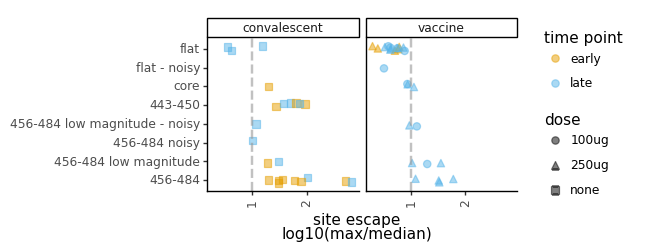

In [16]:
p = (ggplot(metadata_escape) +
     aes('max_over_median_log10', 'escape map', color='time_category', shape='dose') +
     geom_jitter(size=2.5, alpha=0.5, width=0.15, height=0.15, random_state=0) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(4,2),
          )+
     facet_wrap('~sample_type')+
     scale_color_manual(values=CBPALETTE[1:], name='time point')+
     geom_vline(xintercept=1, linetype='dashed', size=1,alpha=0.6, color=CBPALETTE[0])+
     xlab('site escape\nlog10(max/median)')+
     ylab('')
    )

_ = p.draw()

for filetype in ['png', 'pdf']:
    plotfile = f'{resultsdir}/flatness_discrete.{filetype}'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 9 rows containing missing values.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 9 rows containing missing values.


Saving to results/flat_profiles_results//flatness_continuous.png
Saving to results/flat_profiles_results//flatness_continuous.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 9 rows containing missing values.


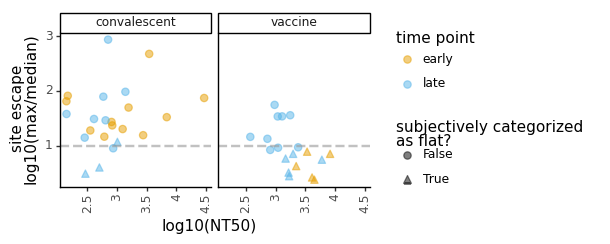

In [17]:
p = (ggplot(metadata_escape) +
     aes('log10_NT50', 'max_over_median_log10', color='time_category', shape='subjectively_flat') +
     geom_jitter(size=2.5, alpha=0.5, width=0, height=0, random_state=0) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(4,2),
          )+
     geom_hline(yintercept=1, linetype='dashed', size=1,alpha=0.6, color=CBPALETTE[0])+
     xlab('log10(NT50)')+
     ylab('site escape\nlog10(max/median)')+
     facet_wrap('~sample_type')+
     scale_color_manual(values=CBPALETTE[1:], name='time point')+
     scale_shape_manual(values=CBMARKERS, name='subjectively categorized\nas flat?')
    )

_ = p.draw()

for filetype in ['png', 'pdf']:
    plotfile = f'{resultsdir}/flatness_continuous.{filetype}'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

In [18]:
!jupyter nbconvert flat_profiles.ipynb --to HTML

[NbConvertApp] Converting notebook flat_profiles.ipynb to HTML
[NbConvertApp] Writing 2170481 bytes to flat_profiles.html
